In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1269.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/623.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/820.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1354.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/45.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/369.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1711.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1173.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1488.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/436.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1409.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/71.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1055.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/215.jpg
/

# **Import LIBS**

In [6]:
from tensorflow.keras.layers import Dense,Flatten,MaxPool2D,Dropout,Conv2D,InputLayer,MaxPooling2D,UpSampling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import keras
from keras import layers
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

# **Import the train and test datasets**

In [7]:

train_dir=r"/kaggle/input/skin-cancer-malignant-vs-benign/train/"
test_dir=r"/kaggle/input/skin-cancer-malignant-vs-benign/test/"

# **Preprocessing The Data**

In [8]:
categories = ['benign','malignant']
y_train = []
x_train = []
x_test = []
y_test = []
Batch_Size = 32
INIT_LR = 1e-4
EPOCHES = 10

In [9]:
from PIL import Image
def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

image_path='/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant/728.jpg'
width, height = get_image_size(image_path)
print(f"Image size: {width}x{height}")


Image size: 224x224


# **Reading The Images From The Train Dataset**

In [10]:
for category in categories:
    path = os.path.join(train_dir,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = cv2.imread(img_path)
        image = cv2.resize(image,(224,224))
        image = image / 255
        x_train.append(image)
        y_train.append(category)

In [11]:
x_train[0]

array([[[0.6745098 , 0.63921569, 0.9254902 ],
        [0.68235294, 0.65098039, 0.92941176],
        [0.68235294, 0.65098039, 0.92941176],
        ...,
        [0.71764706, 0.6745098 , 0.92156863],
        [0.70588235, 0.6745098 , 0.91372549],
        [0.70980392, 0.67843137, 0.91764706]],

       [[0.65882353, 0.62352941, 0.90980392],
        [0.68235294, 0.64705882, 0.93333333],
        [0.6745098 , 0.65098039, 0.92941176],
        ...,
        [0.72941176, 0.67843137, 0.92156863],
        [0.7254902 , 0.6745098 , 0.91764706],
        [0.71372549, 0.67058824, 0.91372549]],

       [[0.64313725, 0.63137255, 0.91372549],
        [0.65098039, 0.63529412, 0.91372549],
        [0.65098039, 0.64313725, 0.91764706],
        ...,
        [0.72941176, 0.67843137, 0.92156863],
        [0.71372549, 0.67058824, 0.91372549],
        [0.7254902 , 0.68235294, 0.9254902 ]],

       ...,

       [[0.71764706, 0.69411765, 0.90980392],
        [0.71372549, 0.69803922, 0.90196078],
        [0.71372549, 0

# **Reading The Images From The Test Dataset**

In [12]:
for category in categories:
    path = os.path.join(test_dir,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = cv2.imread(img_path)
        image = cv2.resize(image,(224,224))
        image = image / 255
        x_test.append(image)
        y_test.append(category)

# **Define the autoencoder architecture**

In [13]:
encoding_dim = 32

input_image = keras.Input(shape=(224*224*3,))
x= layers.Dense(256, activation='relu')(input_image)
x= layers.Dense(128, activation='relu')(x)

encoded = layers.Dense(encoding_dim, activation='relu') (x)
x= layers.Dense(128, activation='relu')(encoded)
x= layers.Dense(256, activation='relu')(x)

decoded = layers.Dense(224*224*3, activation='sigmoid')(x)
autoencoder = keras.Model(input_image, decoded)

In [14]:
encoder = keras.Model(input_image, encoded)

In [15]:
encoded_input = keras.Input(shape=(encoding_dim,))
x= autoencoder.layers[-3](encoded_input)
x= autoencoder.layers[-2](x)
decoder_layer = autoencoder.layers[-1](x)
decoder = keras.Model(encoded_input, decoder_layer)

#################

In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = np.array(x_train,dtype='float32')
x_test = np.array(x_test,dtype='float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(2637, 150528)
(660, 150528)


In [19]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
11/11 [==============================] - 35s 3s/step - loss: 0.6612 - val_loss: 0.6371
Epoch 2/10
11/11 [==============================] - 33s 3s/step - loss: 0.6324 - val_loss: 0.6309
Epoch 3/10
11/11 [==============================] - 33s 3s/step - loss: 0.6293 - val_loss: 0.6286
Epoch 4/10
11/11 [==============================] - 33s 3s/step - loss: 0.6259 - val_loss: 0.6219
Epoch 5/10
11/11 [==============================] - 33s 3s/step - loss: 0.6212 - val_loss: 0.6181
Epoch 6/10
11/11 [==============================] - 36s 3s/step - loss: 0.6172 - val_loss: 0.6139
Epoch 7/10
11/11 [==============================] - 33s 3s/step - loss: 0.6159 - val_loss: 0.6151
Epoch 8/10
11/11 [==============================] - 33s 3s/step - loss: 0.6141 - val_loss: 0.6125
Epoch 9/10
11/11 [==============================] - 34s 3s/step - loss: 0.6127 - val_loss: 0.6114
Epoch 10/10
11/11 [==============================] - 33s 3s/step - loss: 0.6120 - val_loss: 0.6111


In [20]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

21/21 [==============================] - 1s 48ms/step


In [21]:
x_train[0]

array([0.6745098 , 0.6392157 , 0.9254902 , ..., 0.7176471 , 0.69411767,
       0.9098039 ], dtype=float32)

In [22]:
encoded_imgs

array([[23.504675,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [24.091501,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [22.34566 ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [18.89671 ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [14.193222,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 4.31384 ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

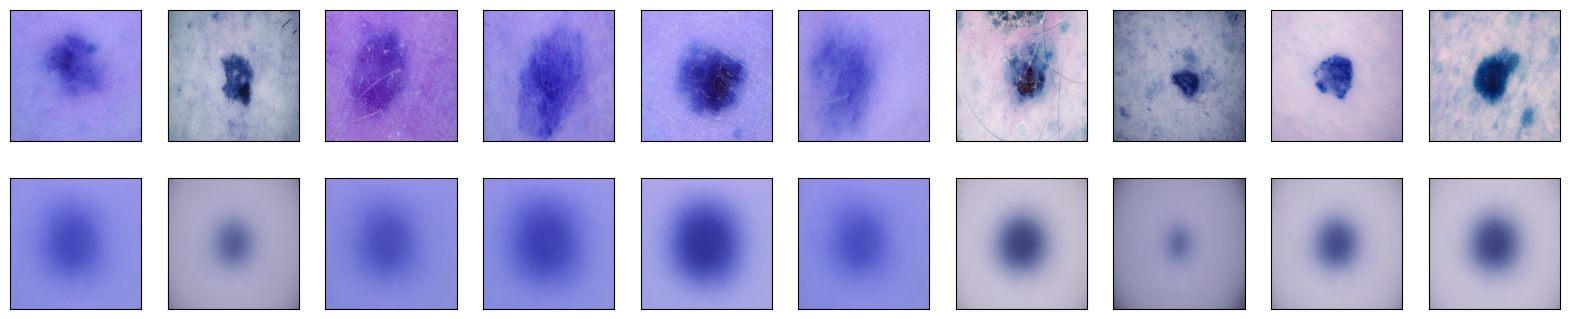

In [23]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    original_img = x_test[i].reshape(224, 224, 3)  # Adjust the reshape dimensions to match the size of x_test[i]
    plt.imshow(original_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_img = decoded_imgs[i].reshape((224, 224, 3))  # Adjust the reshape dimensions to match the size of decoded_imgs[i]
    plt.imshow(reconstructed_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

CNN

In [24]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train,num_classes=2)
y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test,num_classes=2)

In [25]:
x_train = np.array(x_train,dtype='float32')
y_train = np.array(y_train,dtype='float32')
x_test = np.array(x_test,dtype='float32')
y_test = np.array(y_test,dtype='float32')

In [26]:
model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(32,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2,activation='softmax'))

In [27]:
#Regularization
opt = Adam(learning_rate=INIT_LR,weight_decay=INIT_LR/Batch_Size)

In [30]:
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

(None, 224, 224, 3)

In [37]:
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(2637, 150528)
(660, 150528)


In [38]:
model.input_shape

(None, 224, 224, 3)

In [32]:
model.fit(x_train, y_train, epochs=10)


Epoch 1/10


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150528)


In [34]:
x_test_features = autoencoder.encoder(x_test)
test_loss, test_accuracy = dense_classifier.evaluate(x_test_features, y_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy

SyntaxError: incomplete input (2380641261.py, line 5)